In [2]:
# Import the FEMSystem Class from directory above
import sys
sys.path.append('..')
from FEMSystem import FEMSystem

# Remaining Imports
import jax.numpy as jnp
import skfem as fem
from jaxopt import LBFGS
import jax
from FEMSystem import FEMSystem

In [3]:
import platform
print(f"Platform (should NOT be login node like della-gpu but rather something like della-gXXX): {platform.node()}")

Platform (should NOT be login node like della-gpu but rather something like della-gXXX): della-gpu.princeton.edu


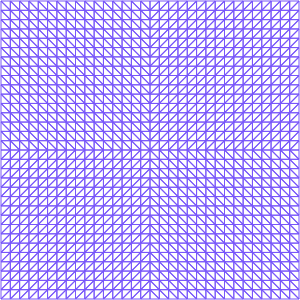

In [10]:
# Create the FEMSystem Object
mesh = fem.MeshTri.init_sqsymmetric().refined(4)
L = 30.0
mesh = mesh.scaled(2 * L).translated((-L, -L))
element = fem.ElementTriP1()
intorder = 4  

femsystem = FEMSystem(mesh,element,intorder,boundary_condition=0)
x,y = (femsystem.doflocs)

# Verify Flipping Works as Intended
# for i in range(femsystem.dofs):
#     print(f"{i} - {femsystem.flip_map[i]}")

# plt.scatter(x,y)

# labels = jnp.arange(femsystem.dofs)
# for i, txt in enumerate(labels):
#     plt.annotate(txt, (x[i], y[i]), # The text and the point to label
#                  textcoords="offset points", # How to position the text
#                  xytext=(0, 10), # Distance from text to points (x,y)
#                  ha='center') # Horizontal alignment of the text
mesh

# Write Problem in Non-Dimensionalized Units

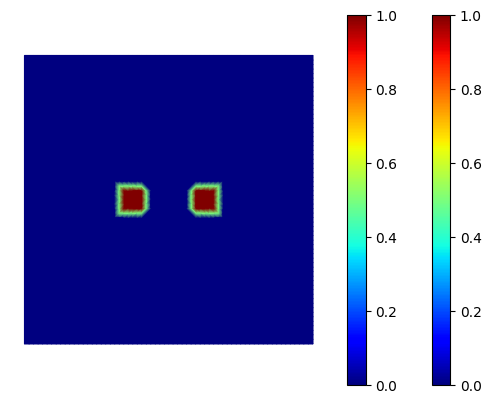

Area is 72


In [11]:
# Step 1: Define the Geometry of two rectangular islands:

sideLen = 6
centerLeft,centerRight = (-7,0), (7,0)
area = 2 * (sideLen ** 2)

def theta(x_vec):
    x,y = x_vec[0],x_vec[1]
    cond1 = (jnp.abs(x-centerLeft[0]) <= sideLen / 2) & (jnp.abs(y-centerLeft[1]) <= sideLen / 2)
    cond2 = (jnp.abs(x-centerRight[0]) <= sideLen / 2) & (jnp.abs(y-centerRight[1]) <= sideLen / 2)
    return cond1 | cond2

def theta_right_only(x_vec):
    x,y = x_vec[0],x_vec[1]
    cond1 = (jnp.abs(x-centerLeft[0]) <= sideLen / 2) & (jnp.abs(y-centerLeft[1]) <= sideLen / 2)
    cond2 = (jnp.abs(x-centerRight[0]) <= sideLen / 2) & (jnp.abs(y-centerRight[1]) <= sideLen / 2)
    return cond1

femsystem.plot_func_2d(lambda a,b: theta([a,b]))
print(f"Area is {area}")

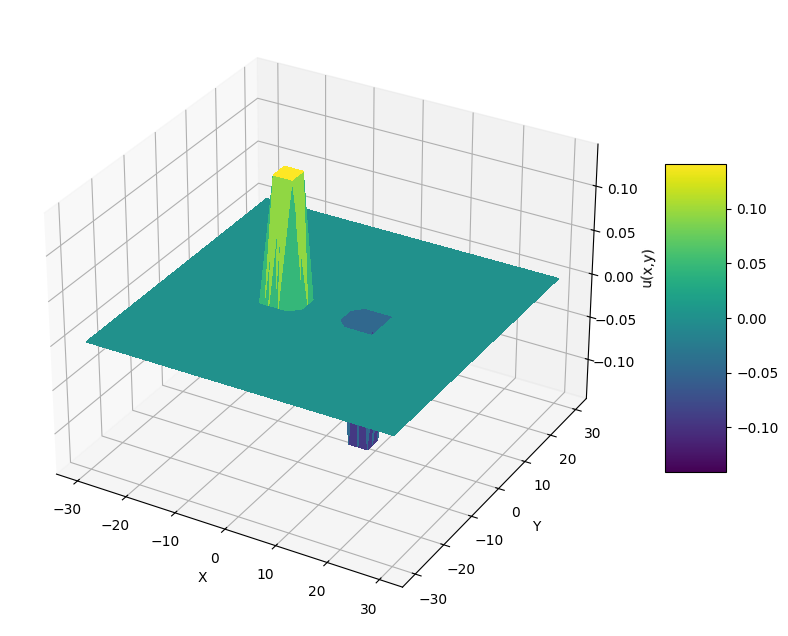

Area Estimate: 63.28125


In [12]:
def laplacian(u,grad_u,x):
    return -1*jnp.sum(grad_u**2,axis=0)

# For Potential Energy Double Inetgral, u1 is our function phi_{+/-} and u2 is theta. 
def u_squared(u,grad_u,u2,grad_u2,x):
    return u**2

# Define Pre-Computed Values for Theta and Green's Function:
def theta_func(u,grad_u,u2,grad_u2,x):
    return u2

epsilon = 1e-20
def G(x_vec,y_vec):
    return - 1 / (2* jnp.pi) * jnp.log(jnp.sqrt(jnp.sum((x_vec-y_vec)**2,axis=-1)) + epsilon)

theta_at_dofs = theta(femsystem.doflocs).astype(jnp.float32)
G_mat = femsystem.get_sparse_interaction_mat(G)

# Define interaction terms

# U_{++++} or U_{----}
def alpha(u,G_mat):
    return area * femsystem.double_integral(lambda u1,a,b,c,d: u1**2,lambda u1,a,b,c,d: u1**2,G_mat,u,u)

# U_{+--+} = U{-++-} - Remember middle two are wrt to y, Outer two wrt to x, from notation used in doc
def beta(u1_arg,u2_arg,G_mat):
    return femsystem.double_integral(lambda u1,a,b,c,d: u1**2, lambda a,b,u2,c,d: u2**2, G_mat, u1_arg,u2_arg)

# U_{++--} = U{+-+-}
def gamma(u1_arg,u2_arg,G_mat):
    return femsystem.double_integral(lambda u1,a,u2,c,d: u1*u2, lambda u1,b,u2,c,d: u1*u2, G_mat, u1_arg,u2_arg)


# VERY VERY IMPORTANT TO PASS IN G_mat AS AN ARGUMENT, AND SET TO CONSTANT IN OPTIMIZATION LOOP
# This is because when JAX compiles this function, it will treat the G_mat as a "tracer", so just any matrix of constants with some shape. 
# If you hardcode it into the function, it will treat it as an actual part of the code and will spent time compiling a massive amount of hardcoded values as "code" essentially. This is why it takes almost 10 minutes to run first optimization iteration. 
# @jax.jit


def epsilon_func(u_global,G_mat):
    # Kinetic Term
    kinetic = -4 * femsystem.integrate(laplacian,u_global)

    # Potential Term
    potential = -2 * femsystem.double_integral(u_squared,theta_func,G_mat,u_global,theta_at_dofs)

    return kinetic + potential

@jax.jit
def objective_with_interactions(u_interior,G_mat):
    u_even,u_odd = femsystem.separate_even_odd_apply_by_and_norm(u_interior)

    # Non-Interactions
    non_interactions = ( epsilon_func(u_even,G_mat) + epsilon_func(u_odd,G_mat) ) / 2 # e++ + e-- / 2

    # Interactions
    a,b,c = 1,0,0 # Tune Interaction Strength, "Effective Charge"
    interaction_a = a * (alpha(u_even,G_mat) + alpha(u_odd,G_mat))
    interaction_b = b * beta(u_even,u_odd,G_mat)
    interaction_c = c * gamma(u_even,u_odd,G_mat)
    interactions = interaction_a + interaction_b + interaction_c

    return non_interactions #+ interactions


# Test that it doesn't give an error
u_init_interior = femsystem.ones_on_island(theta_right_only)
temp = objective_with_interactions(u_init_interior,G_mat)
u_even,u_odd = femsystem.separate_even_odd_apply_by_and_norm(u_init_interior)
femsystem.plot_at_interior_2d_in3d(u_odd[femsystem.interior_dofs])
print(f"Area Estimate: {femsystem.integrate(lambda u,grad_u,x: u,theta_at_dofs)}")

In [6]:
# Optimization Loop

# Very important to initialize to random instead of all ones, or else odd mode is trivial
# u_init_interior = femsystem.get_initial_random_interior()

print("Starting Optimization")
solver = LBFGS(fun=objective_with_interactions,tol=1e-2,verbose=True)
result = solver.run(u_init_interior,G_mat)
result = result.params 
u_interior = result

Starting Optimization
INFO: jaxopt.LBFGS: Iter: 1 Gradient Norm (stopping criterion): 2.3135623931884766 Objective Value:13.831993103027344  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 2 Gradient Norm (stopping criterion): 0.9297732710838318 Objective Value:12.591412544250488  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 3 Gradient Norm (stopping criterion): 0.34192460775375366 Objective Value:12.337699890136719  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 4 Gradient Norm (stopping criterion): 0.1888589859008789 Objective Value:12.313770294189453  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 5 Gradient Norm (stopping criterion): 0.04706184193491936 Objective Value:12.309062957763672  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 6 Gradient Norm (stopping criterion): 0.015258326195180416 Objective Value:12.308761596679688  Stepsize:1.0  Number Linesearc

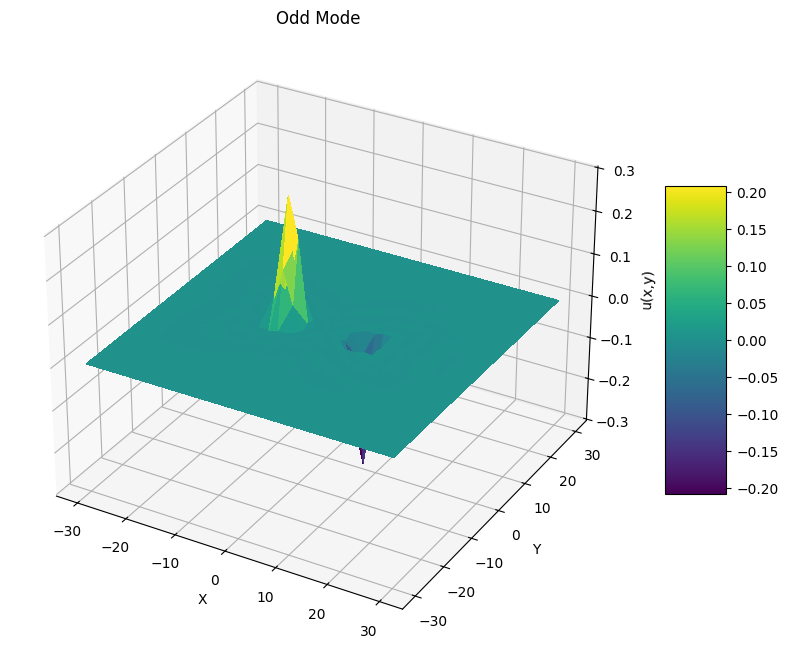

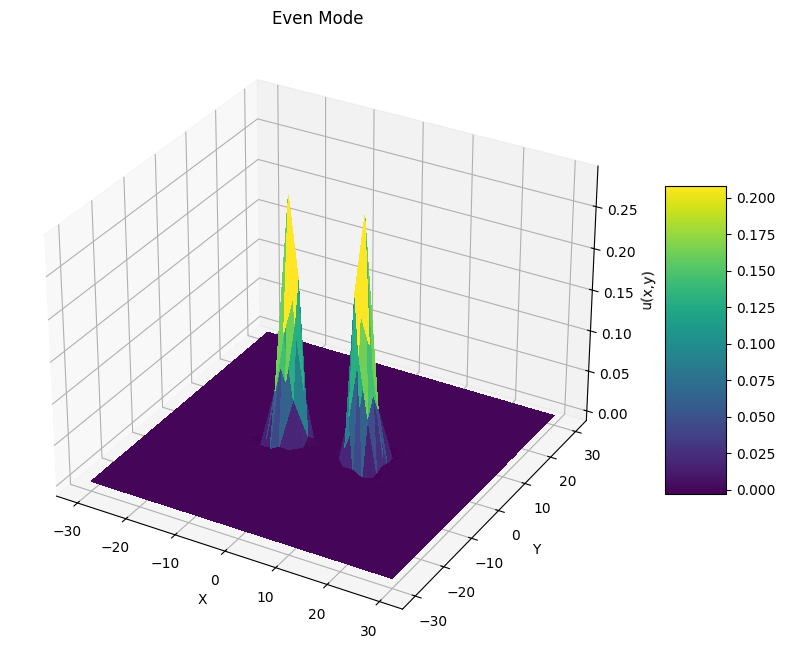

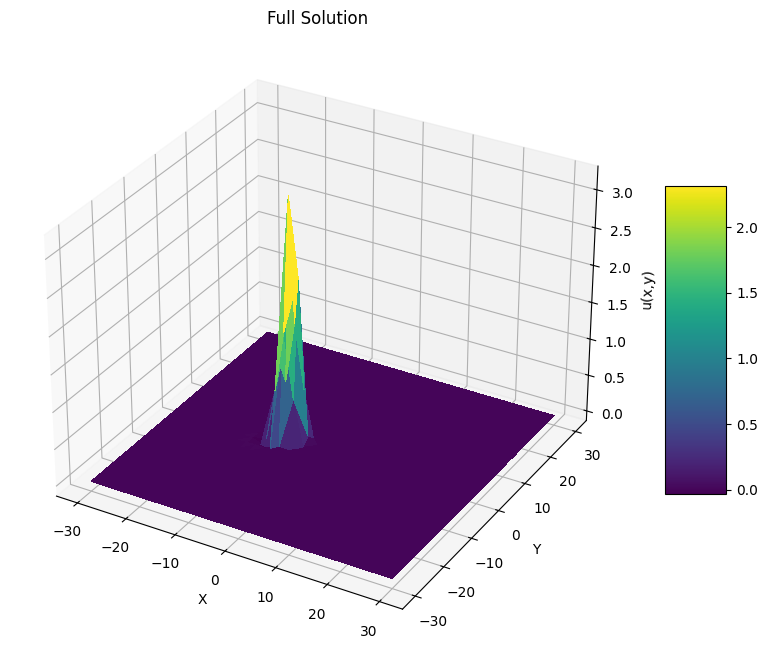

: 

In [ ]:
# Get Even and Odd Modes
u_even,u_odd = femsystem.separate_even_odd_apply_by_and_norm(u_interior)
u_even_interior,u_odd_interior = u_even[femsystem.interior_dofs],u_odd[femsystem.interior_dofs]

femsystem.plot_at_interior_2d_in3d(u_odd_interior,plot_title="Odd Mode")
femsystem.plot_at_interior_2d_in3d(u_even_interior,plot_title="Even Mode")
femsystem.plot_at_interior_2d_in3d(u_interior,plot_title="Full Solution")